In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential
plt.style.use('fivethirtyeight')


In [2]:
file_path = 'D:/New folder/machinelearning/projects/electricity consumption using rnn/PJME_hourly.csv'
df = pd.read_csv(file_path).set_index('Datetime')
df=df.sort_index()
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [3]:
df.isna().sum()

PJME_MW    0
dtype: int64

In [4]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2+ MB


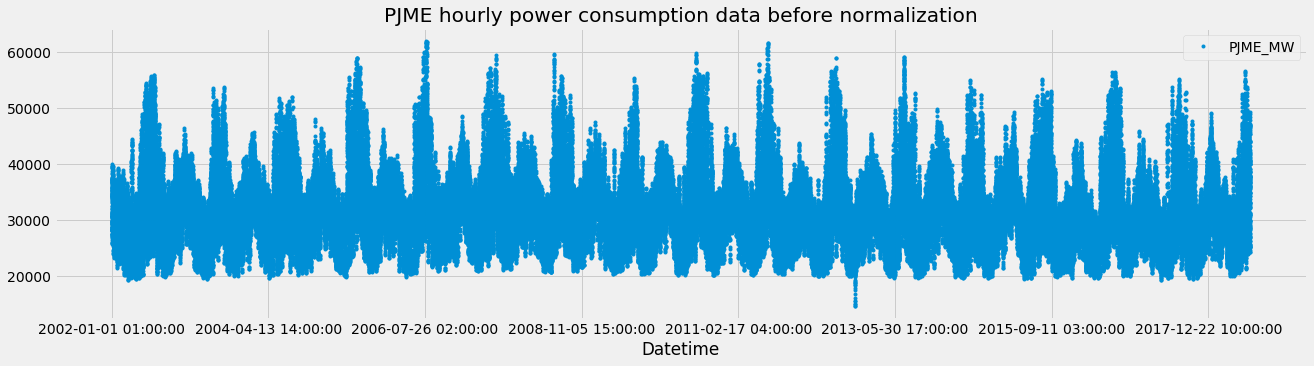

In [6]:
df.plot(style='.',figsize=(20,5),legend=True)
plt.title('PJME hourly power consumption data before normalization')
plt.show()

In [7]:
df.iloc[140000]

PJME_MW    34739.0
Name: 2017-12-22 10:00:00, dtype: float64

In [8]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['PJME_MW'] = scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
df_norm = df
df_norm.shape

(145366, 1)

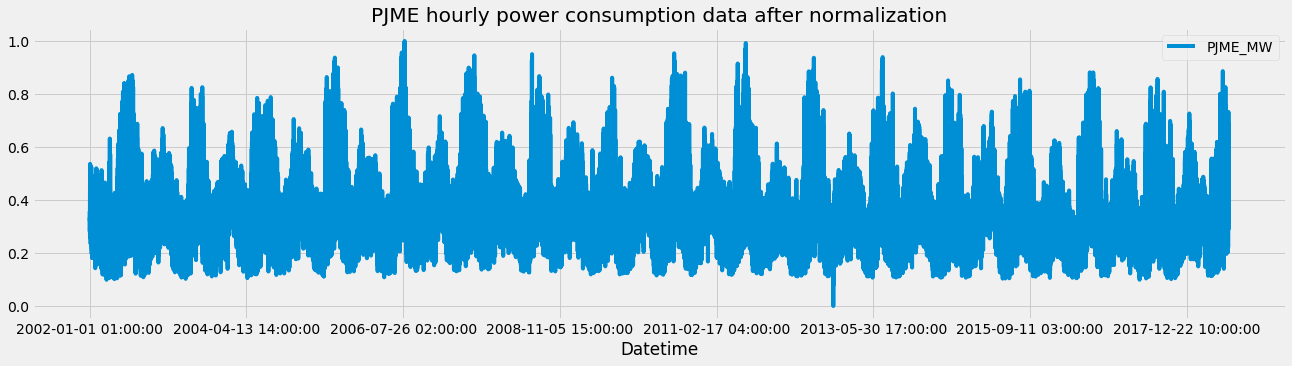

In [9]:
df_norm.plot(figsize=(20,5),legend=True)
plt.title('PJME hourly power consumption data after normalization')
plt.show()

In [10]:
df_norm.shape

(145366, 1)

In [11]:
def load_data(data_frame, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(data_frame)):
        X_train.append(data_frame.iloc[i-seq_len : i, 0])
        y_train.append(data_frame.iloc[i, 0])
    
    #1 last 5366 days are going to be used in test
    X_test = X_train[140000:]             
    y_test = y_train[140000:]
    
    #2 first 140000 days are going to be used in training
    X_train = X_train[:140000]           
    y_train = y_train[:140000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (140000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [12]:
#create train, test data
seq_len = 90 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (140000, 90, 1)
y_train.shape =  (140000,)
X_test.shape =  (5276, 90, 1)
y_test.shape =  (5276,)


In [13]:
df.iloc[140000]

PJME_MW    0.425471
Name: 2017-12-22 10:00:00, dtype: float64

In [14]:
lstm_model = Sequential()

lstm_model.add(LSTM(50,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(50,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(50,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(50,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 90, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [15]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=30, batch_size=1000)

Epoch 1/30
140/140 [==============================] - 9s 66ms/step - loss: 0.0173
Epoch 2/30
140/140 [==============================] - 9s 67ms/step - loss: 0.0062
Epoch 3/30
140/140 [==============================] - 9s 67ms/step - loss: 0.0046
Epoch 4/30
140/140 [==============================] - 9s 67ms/step - loss: 0.0038
Epoch 5/30
140/140 [==============================] - 9s 67ms/step - loss: 0.0034
Epoch 6/30
140/140 [==============================] - 9s 67ms/step - loss: 0.0032
Epoch 7/30
140/140 [==============================] - 9s 67ms/step - loss: 0.0030
Epoch 8/30
140/140 [==============================] - 9s 67ms/step - loss: 0.0029
Epoch 9/30
140/140 [==============================] - 9s 67ms/step - loss: 0.0028
Epoch 10/30
140/140 [==============================] - 9s 67ms/step - loss: 0.0026
Epoch 11/30
140/140 [==============================] - 9s 68ms/step - loss: 0.0023
Epoch 12/30
140/140 [==============================] - 10s 68ms/step - loss: 0.0021
Epoch 13/30


In [16]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9872456433812582


lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test = scaler.inverse_transform(y_test)

In [17]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

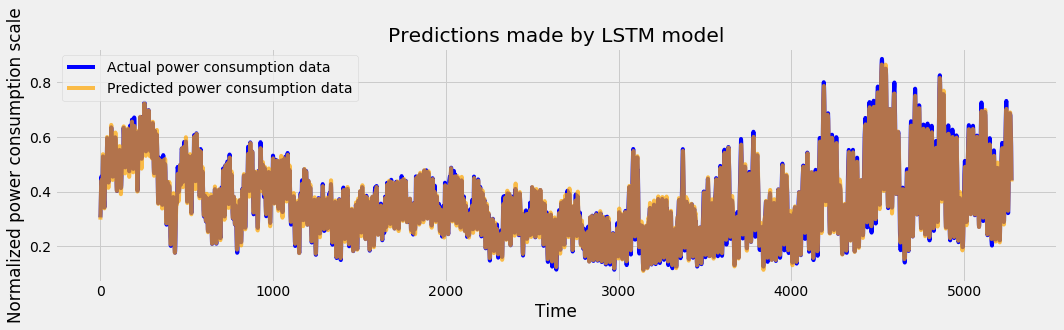

In [18]:

plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [19]:
mae= tf.keras.losses.MAE(
    y_test,lstm_predictions
)

print(mae)

tf.Tensor([0.11173043 0.10584731 0.10349162 ... 0.20257841 0.16346015 0.12717788], shape=(5276,), dtype=float32)


In [20]:
sum(mae)

<tf.Tensor: shape=(), dtype=float32, numpy=763.27155>

In [21]:
x_time = df.index[-5276:]
print(x_time)

Index(['2017-12-26 04:00:00', '2017-12-26 05:00:00', '2017-12-26 06:00:00',
       '2017-12-26 07:00:00', '2017-12-26 08:00:00', '2017-12-26 09:00:00',
       '2017-12-26 10:00:00', '2017-12-26 11:00:00', '2017-12-26 12:00:00',
       '2017-12-26 13:00:00',
       ...
       '2018-08-02 15:00:00', '2018-08-02 16:00:00', '2018-08-02 17:00:00',
       '2018-08-02 18:00:00', '2018-08-02 19:00:00', '2018-08-02 20:00:00',
       '2018-08-02 21:00:00', '2018-08-02 22:00:00', '2018-08-02 23:00:00',
       '2018-08-03 00:00:00'],
      dtype='object', name='Datetime', length=5276)


In [22]:
y_test_org = scaler.inverse_transform(y_test.reshape(-1,1))

In [23]:
predicted_mw = scaler.inverse_transform(lstm_predictions.reshape(-1,1))

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_test_org,predicted_mw)

506425.9692972377

In [25]:
mean_absolute_error(y_test_org,predicted_mw)

558.3128076282932

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
mean_absolute_percentage_error(y_test_org,predicted_mw)

1.7679015285347548

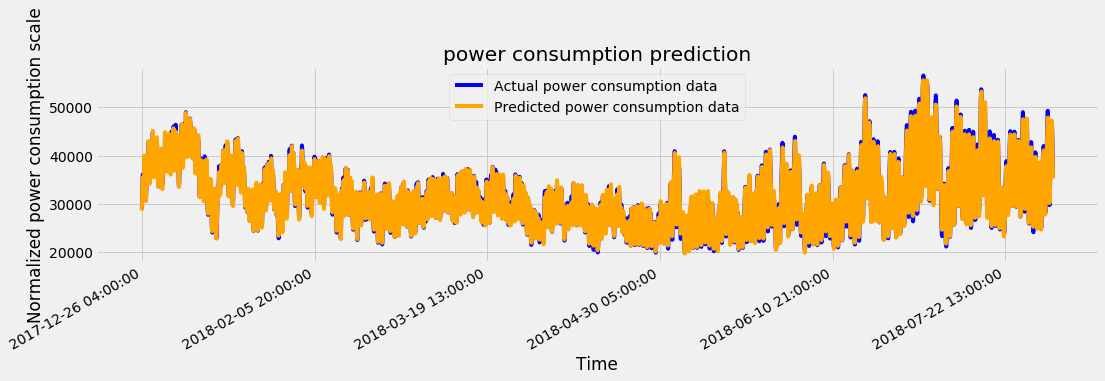

In [28]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(16,4))
ax1= fig.add_subplot(111)
plt.xticks()
plt.plot(x_time ,y_test_org,color='blue',label='Actual power consumption data')
plt.plot(x_time,predicted_mw, color='orange',label='Predicted power consumption data')
tick_spacing = 1000
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.title("power consumption prediction")
plt.xlabel('Time')
plt.ylabel('Normalized power consumption scale')
plt.legend()
plt.show()